In [4]:
import numpy as np
p = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\Output\\eddy_prob\\eddy_prob_t00000.npy")
print(p.min(), p.max(), p.mean(), (p>0).mean())


0.0 0.0 0.0 0.0


In [6]:
m = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\eddy_mask_2000-2010.npy")[0]  # 0/1/2
pred = (p >= 0.5).astype(np.int32)
gt = (m > 0).astype(np.int32)
iou = (pred & gt).sum() / ((pred | gt).sum() + 1e-6)
print("IoU:", iou)


IoU: 0.0


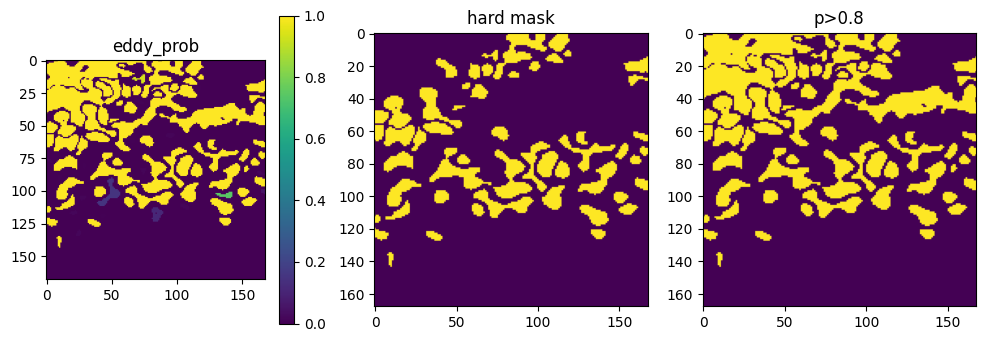

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pwd = "D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\"

a = 0
p = np.load(f"{pwd}Output\\eddy_prob\\eddy_prob_t{a:05d}.npy")
m = np.load(f"{pwd}data\\eddy_mask_2000-2010.npy")[a]  # 原 hard mask

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("eddy_prob"); plt.imshow(p); plt.colorbar()
plt.subplot(1,3,2); plt.title("hard mask"); plt.imshow(m>0)
plt.subplot(1,3,3); plt.title("p>0.8"); plt.imshow(p>=0.8)
plt.show()
